# case study group 23

> You are an employee of a fictitious company “106”, which sells gearshift systems to car manufacturers. In order to improve the product of the automatic gearshift system “K3AG1”, your company plans to analyze the damage cases of the last years. The automatic gearshift “K3AG1” is a standard component of the car brand “OEM1” and can be selected by the customer as an equipment feature of the car types “Type11” or “Type12”. From the management of your department you get the task to analyze the production data and parts lists of the customer and your suppliers. Key performance indicators such as service life, mileage, failure rates and usage data are of great importance.

## 1. Importing the data

In [33]:
import os
from typing import List
import pandas as pd
import numpy as np
def read_csv_auto(path: str) -> pd.DataFrame:
    """Read CSV with automatic delimiter detection and robust date parsing off (we'll parse later)."""
    df = pd.read_csv(path, sep=None, engine="python", dtype=str)
    # Drop typical unnamed index columns, if any
    df = df.loc[:, ~df.columns.str.contains(r"^Unnamed", case=False)]
    # Strip quotes/spaces from column names
    df.columns = df.columns.str.strip().str.replace('"', '', regex=False)
    # Strip surrounding quotes/spaces from string cells
    for col in df.select_dtypes(include=["object"]).columns:
        df[col] = df[col].map(lambda x: x.strip().strip('"') if isinstance(x, str) else x)
    return df

# Vehicles (baseline)
path_typ11 = "data/Fahrzeug/Fahrzeuge_OEM1_Typ11.csv"
path_typ12 = "data/Fahrzeug/Fahrzeuge_OEM1_Typ12.csv"

# Registrations
# path_reg   = "source/Zulassungen/Zulassungen_alle_Fahrzeuge.csv"

# Parts per vehicle
path_parts11 = "data/Fahrzeug/Bestandteile_Fahrzeuge_OEM1_Typ11.csv"
path_parts12 = "data/Fahrzeug/Bestandteile_Fahrzeuge_OEM1_Typ12.csv"

# Component (K3AG1)
path_k3ag1   = "data/Komponente/Komponente_K3AG1.csv"
# path_k3AG1_parts = "Bestandteile_Komponente_K3AG1.csv"

# Component (K3SG1)
path_k3sg1 = "data/Komponente/Komponente_K3SG1.csv"

df_typ11  = read_csv_auto(path_typ11)
df_typ12  = read_csv_auto(path_typ12)
# df_reg    = read_csv_auto(path_reg)
df_parts11 = read_csv_auto(path_parts11)
df_parts12 = read_csv_auto(path_parts12)
df_k3ag1  = read_csv_auto(path_k3ag1)
df_k3sg1 = read_csv_auto(path_k3sg1)


FileNotFoundError: [Errno 2] No such file or directory: 'data/Fahrzeug/Fahrzeuge_OEM1_Typ11.csv'

## 2. Data preparation

In [35]:
def coalesce_first(df: pd.DataFrame, candidates: List[str], new_name: str) -> pd.DataFrame:
    """
    Create/overwrite df[new_name] with the first existing, non-null column among candidates.
    If none exist, the column is created with NaN.
    """
    values = None
    for c in candidates:
        if c in df.columns:
            values = df[c] if values is None else values.fillna(df[c])
    df[new_name] = values if values is not None else np.nan
    return df

# Vehicles: ensure presence of the vehicle ID column name 'ID_Fahrzeug'
# (Some exports may have it quoted; read_csv_auto already strips quotes.)
if "ID_Fahrzeug" not in df_typ11.columns:
    # Attempt to find a close match; fallback to no-op if absent.
    pass
if "ID_Fahrzeug" not in df_typ12.columns:
    pass

# Tag vehicle type for provenance
if len(df_typ11):
    df_typ11["vehicle_type"] = "Typ11"
if len(df_typ12):
    df_typ12["vehicle_type"] = "Typ12"

# Baseline vehicles: stack, keep all columns; align by column name
df_vehicles_base = pd.concat([df_typ11, df_typ12], ignore_index=True, sort=False)

# Parts: unify the two parts tables and keep the shared columns
# Expected keys include: ID_Karosserie, ID_Schaltung, ID_Sitze, ID_Motor, ID_Fahrzeug
df_parts_all = pd.concat([df_parts11, df_parts12], ignore_index=True, sort=False)

# Registrations: standardize join key name to 'ID_Fahrzeug' and rename to English labels
# Some files name the vehicle ID as 'IDNummer'
# if "IDNummer" in df_reg.columns and "ID_Fahrzeug" not in df_reg.columns:
#     df_reg = df_reg.rename(columns={"IDNummer": "ID_Fahrzeug"})
# df_reg = df_reg.rename(columns={
#     "Gemeinden": "registration_municipality",
#     "Zulassung": "registration_date",
# })

def clean_k3_dataframe(df):
    df = coalesce_first(
        df,
        candidates=["ID_Schaltung", "ID_Schaltung.x", "ID_Schaltung.y"],
        new_name="ID_Schaltung"
    )   
    
    df = coalesce_first(df,
        ["Produktionsdatum", "Produktionsdatum.x", "Produktionsdatum.y"],
        "transmission_production_date"
    )
    df = coalesce_first(df,
        ["Herstellernummer", "Herstellernummer.x", "Herstellernummer.y"],
        "transmission_manufacturer_no"
    )
    df = coalesce_first(df,
        ["Werksnummer", "Werksnummer.x", "Werksnummer.y"],
        "transmission_plant_no"
    )
    df = coalesce_first(df,
        ["Fehlerhaft", "Fehlerhaft.x", "Fehlerhaft.y"],
        "transmission_defective_flag"
    )
    df = coalesce_first(df,
        ["Fehlerhaft_Datum", "Fehlerhaft_Datum.x", "Fehlerhaft_Datum.y"],
        "transmission_defective_date"
    )
    df = coalesce_first(df,
        ["Fehlerhaft_Fahrleistung", "Fehlerhaft_Fahrleistung.x", "Fehlerhaft_Fahrleistung.y"],
        "transmission_defective_mileage"
    )

    # Keep only the columns we standardized plus the join key
    keep_cols_k3 = [
        "ID_Schaltung",
        "transmission_production_date",
        "transmission_manufacturer_no",
        "transmission_plant_no",
        "transmission_defective_flag",
        "transmission_defective_date",
        "transmission_defective_mileage",
    ]

    keep_cols_k3 = [c for c in keep_cols_k3 if c in df.columns]
    df = df[keep_cols_k3].drop_duplicates()


    return df

df_k3 = pd.concat([df_k3ag1, df_k3sg1], axis = 0, ignore_index=True)
df_k3 = clean_k3_dataframe(df_k3)

NameError: name 'df_typ11' is not defined

## 3. Creation of the final dataset

In [37]:
# Merge with parts (by vehicle)
df_merged = df_vehicles_base.merge(
    df_parts_all,
    how="left",
    on="ID_Fahrzeug",
    suffixes=("", "_parts"),
    validate="m:1"
)

# Merge with K3AG1/K3SG1 component (by transmission ID from parts)
df_merged = df_merged.merge(
    df_k3,
    how="left",
    on="ID_Schaltung",
    validate="m:1"
)

rename_map = {
    "ID_Fahrzeug": "vehicle_id",
    "Produktionsdatum": "vehicle_production_date",
    "Herstellernummer": "vehicle_manufacturer_no",
    "Werksnummer": "vehicle_plant_no",
    "Fehlerhaft": "vehicle_defective_flag",
    "Fehlerhaft_Datum": "vehicle_defective_date",
    "Fehlerhaft_Fahrleistung": "vehicle_defective_mileage",
    "ID_Schaltung": "transmission_id"
}

df_merged = df_merged.rename(columns=rename_map)

date_like_cols = [c for c in [
    "registration_date",
    "transmission_production_date",
    "transmission_defective_date",
] if c in df_merged.columns]

for c in date_like_cols:
    try:
        parsed = pd.to_datetime(df_merged[c], errors="coerce")
        # Keep ISO-8601 string for portability
        df_merged[c] = parsed.dt.strftime("%Y-%m-%d")
    except Exception:
        # Leave as-is on any parsing issues
        pass

df_keeps = df_merged[[ 
    'vehicle_id', 
    'vehicle_production_date',
    'transmission_id', 
    'transmission_production_date',  'transmission_defective_flag',
    'transmission_defective_date', 'transmission_defective_mileage']]

# Ensure output directory exists
output_path = "Final_dataset_group_23.csv"

# Write CSV (UTF-8, comma delimiter, English-friendly headers we added remain in English)
df_keeps.to_csv(output_path, index=False, encoding="utf-8")
df_keeps.to_csv(f"{output_path}.gz", index=False, compression="gzip")   # gzip


NameError: name 'df_vehicles_base' is not defined

## 4. Evaluation

Scanning folder: C:\Users\16499\Documents\123
Found a matching file: Final_dataset_group_23.csv
Attempting to read file: C:\Users\16499\Documents\123\Final_dataset_group_23.csv

File successfully read as CSV!

--- Step 2: Verifying the Core Problem ---
Overall Fault Rate for all vehicles: 10.56%

Fault Rate by Vehicle Type:
VehicleType
11-1-11    0.105544
11-1-12    0.105646
12-1-12    0.105943
Name: transmission_defective_flag, dtype: float64

--- Step 3: Focusing in-depth analysis on the most common model: 11-1-11 ---

--- Step 4: Analyzing WHEN failures occur for model 11-1-11 ---

Chart 1 (Time-to-Failure) generated, displaying now.


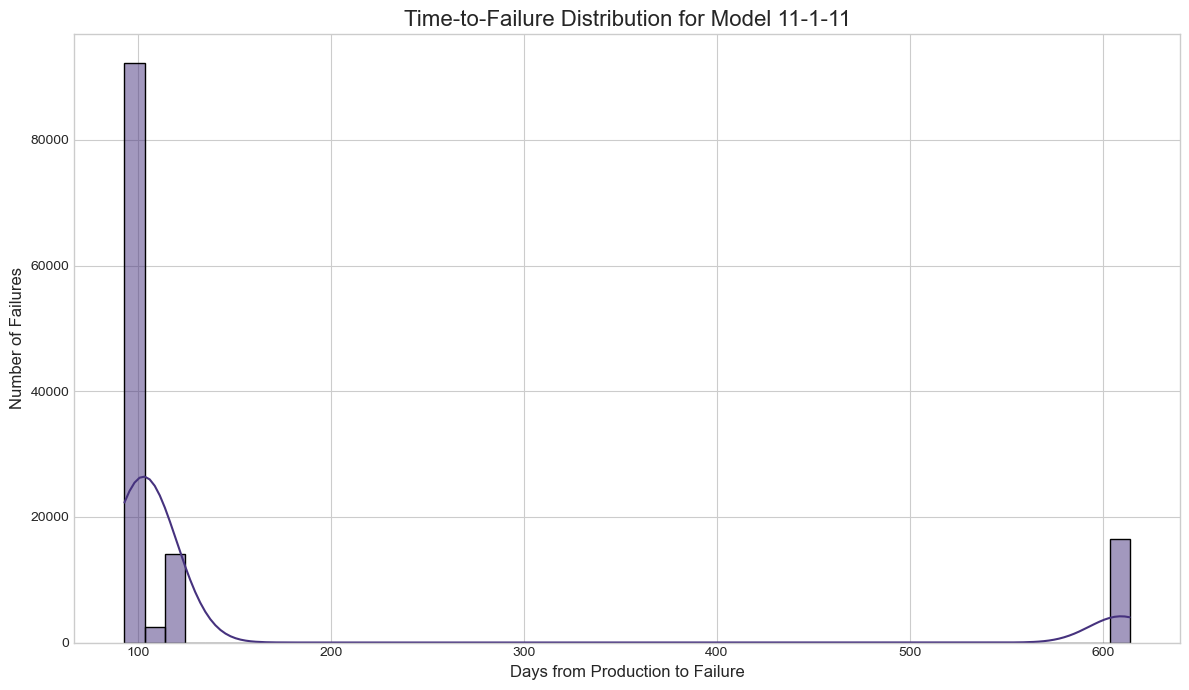


Chart 2 (Mileage-at-Failure) generated, displaying now.


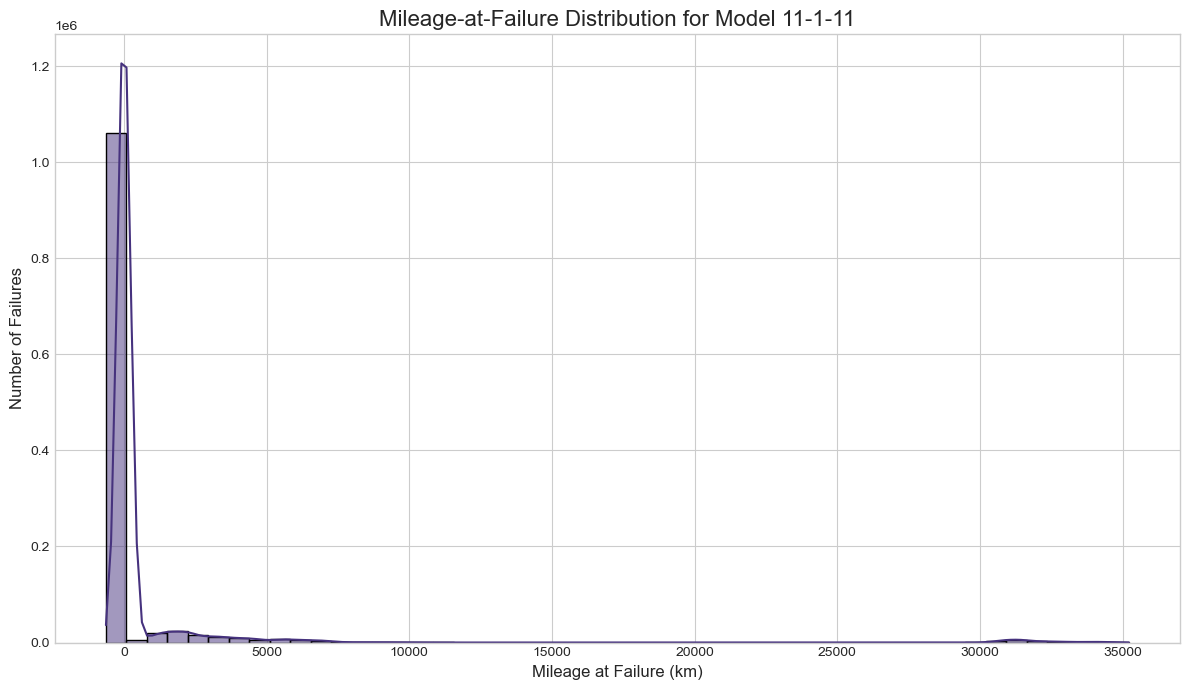


--- Step 5: Investigating Production Batch Patterns for model 11-1-11 ---

Chart 3 (Fault Heatmap) generated, displaying now.


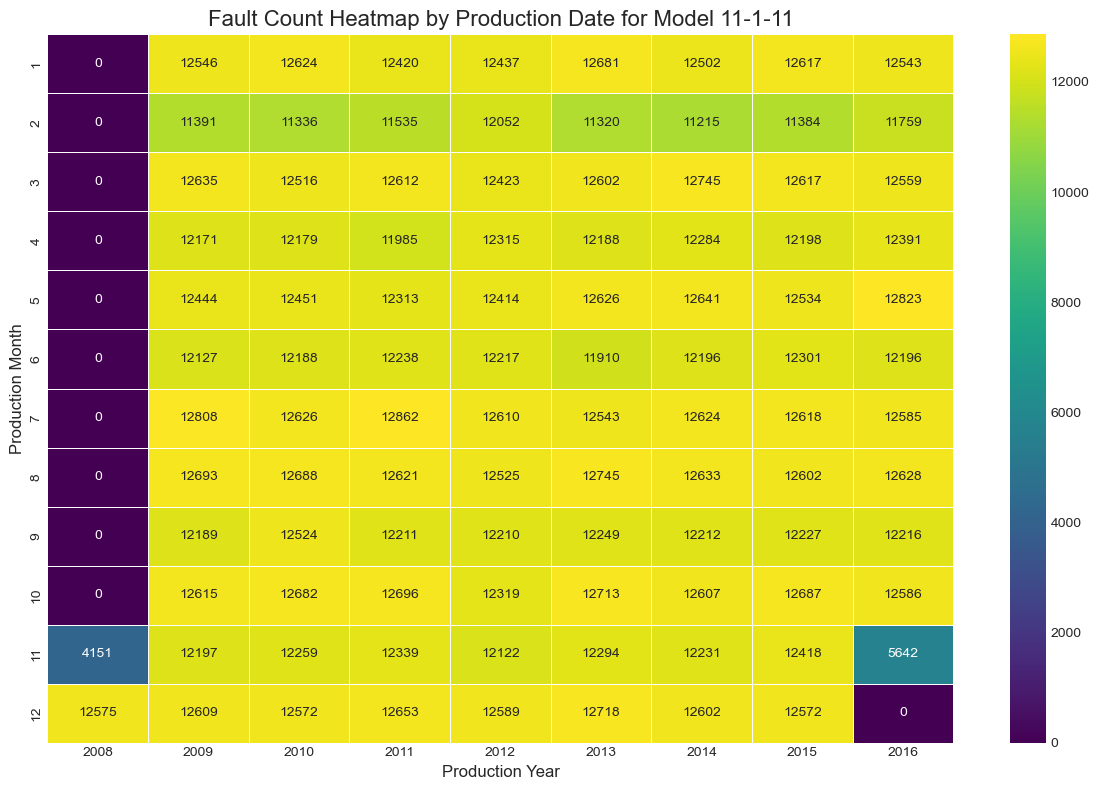


--- Step 6: Comparing the focused model with other models ---

Chart 4 (Comparative Time-to-Failure) generated, displaying now.


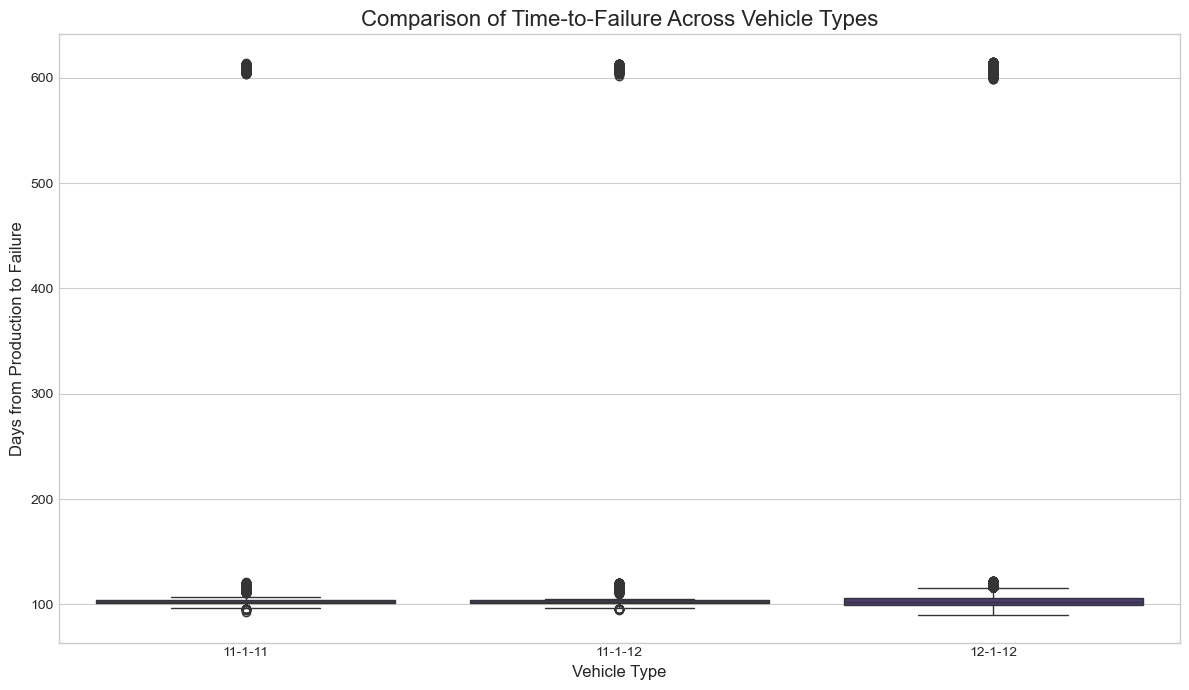


Chart 5 (Comparative Mileage-at-Failure) generated, displaying now.


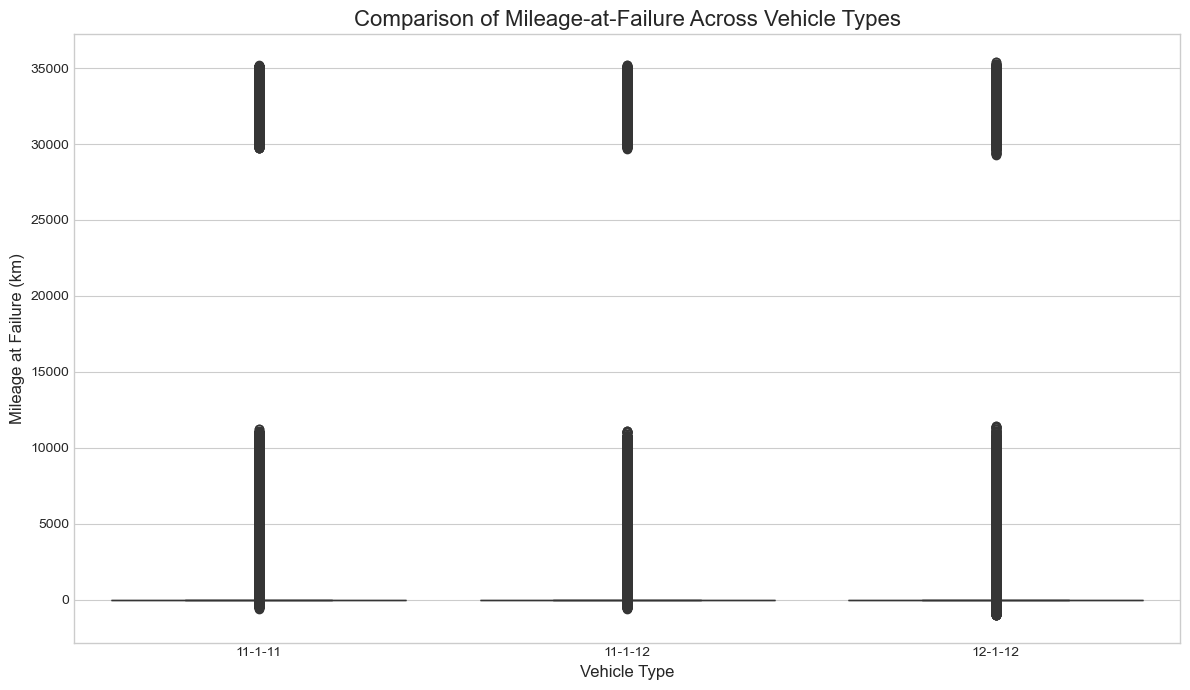


--- Step 7: Analyzing Manufacturer Performance for model 11-1-11 ---

Chart 6 (Manufacturer Performance) generated, displaying now.


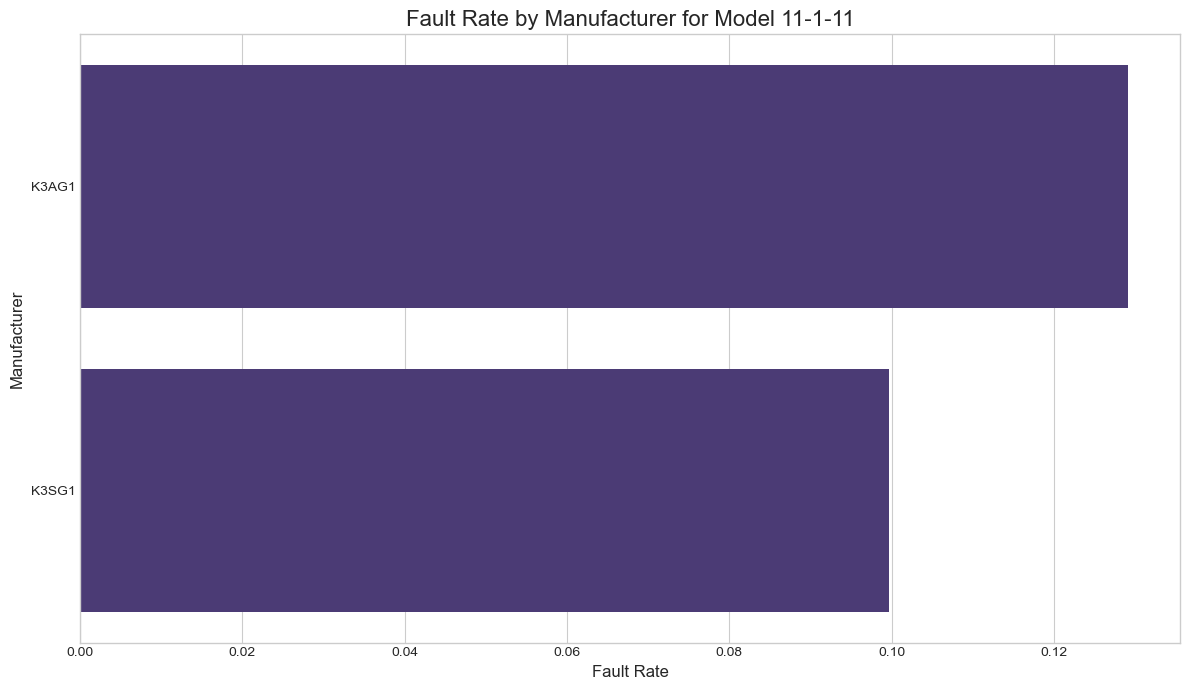


--- Step 8: Analyzing Production Lead Time vs. Fault ---

Chart 7 (Production Lead Time) generated, displaying now.


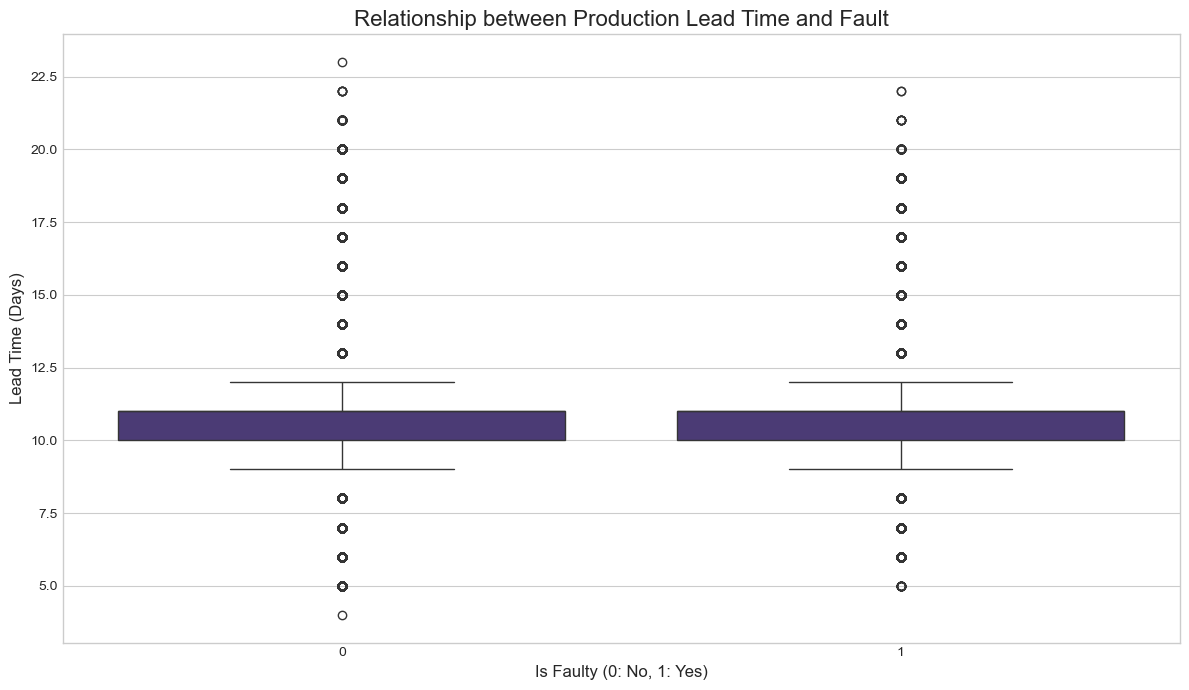


--- Step 9: Analyzing Variable Correlation ---

Chart 8 (Correlation Heatmap) generated, displaying now.


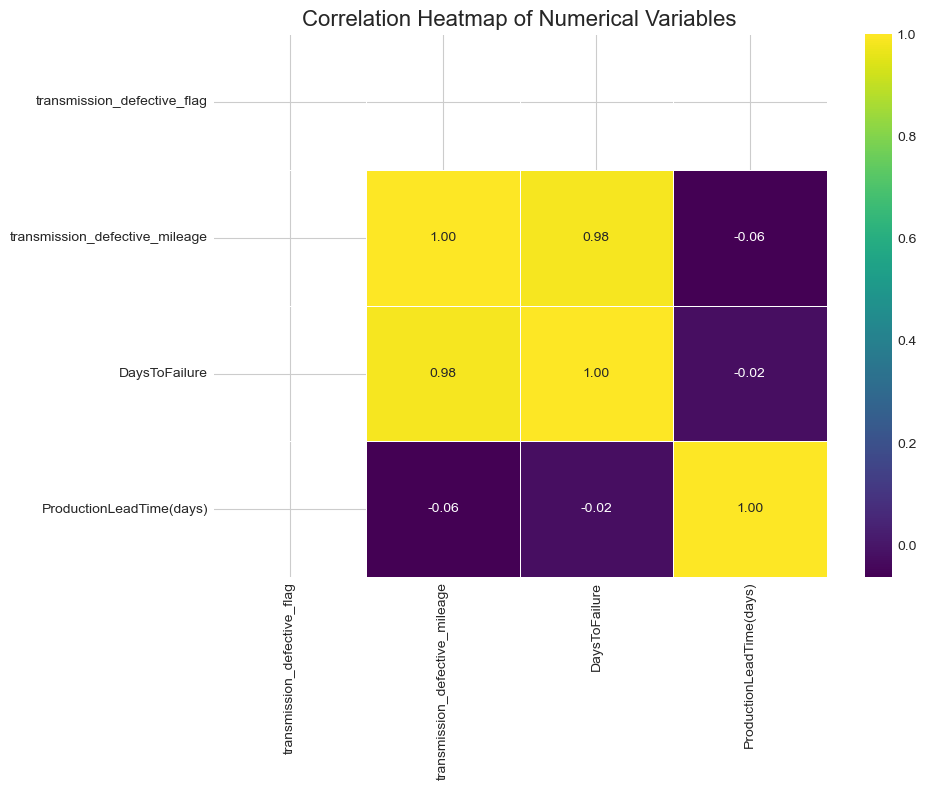

In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# --- Analysis Configuration ---
# Set a unified, professional color palette for all charts
sns.set_palette("viridis")
plt.style.use('seaborn-v0_8-whitegrid')

# --- Step 1: Read Data (Same as before) ---

# Specify the folder path to search
folder_path = r"C:\Users\16499\Documents\123"

# The base filename we are looking for (without extension)
target_filename_base = "Final_dataset_group_23"

# Check if the folder exists
if not os.path.isdir(folder_path):
    print(f"Error: Folder not found at '{folder_path}'. Please confirm the path is correct.")
else:
    print(f"Scanning folder: {folder_path}")
    
    found_file_path = None
    
    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        name_part, extension = os.path.splitext(filename)
        if name_part == target_filename_base:
            found_file_path = os.path.join(folder_path, filename)
            print(f"Found a matching file: {filename}")
            break

    # If a file was found
    if found_file_path:
        try:
            print(f"Attempting to read file: {found_file_path}")
            
            file_extension = os.path.splitext(found_file_path)[1].lower()

            if file_extension == '.csv':
                df = pd.read_csv(found_file_path)
                print("\nFile successfully read as CSV!")
            else:
                print(f"\nError: Unsupported file type '{file_extension}'.")
                df = None

            if df is not None:
                # --- Data Preprocessing and Feature Engineering ---
                fault_col = 'transmission_defective_flag'
                date_col = 'vehicle_production_date'
                fault_date_col = 'transmission_defective_date'
                mileage_col = 'transmission_defective_mileage'
                transmission_col = 'transmission_id'
                transmission_date_col = 'transmission_production_date'
                
                # Convert date columns to datetime objects
                df[date_col] = pd.to_datetime(df[date_col])
                df[fault_date_col] = pd.to_datetime(df[fault_date_col])
                df[transmission_date_col] = pd.to_datetime(df[transmission_date_col])
                
                # Define Vehicle Type (using first 3 parts of ID for meaningful grouping)
                df['VehicleType'] = df['vehicle_id'].str.split('-').str[:3].str.join('-')
                
                # --- Step 2: Initial Data Verification (The Starting Point) ---
                print("\n--- Step 2: Verifying the Core Problem ---")
                overall_fault_rate = df[fault_col].mean()
                print(f"Overall Fault Rate for all vehicles: {overall_fault_rate:.2%}")

                type_fault_rates = df.groupby('VehicleType')[fault_col].mean()
                print("\nFault Rate by Vehicle Type:")
                print(type_fault_rates)

                # --- Step 3: Focus on the Primary Product Model ---
                # Identify the most produced vehicle type as the focus of our analysis
                focus_vehicle_type = df['VehicleType'].mode()[0]
                print(f"\n--- Step 3: Focusing in-depth analysis on the most common model: {focus_vehicle_type} ---")
                df_focus = df[df['VehicleType'] == focus_vehicle_type].copy()
                
                # Calculate Time-to-Failure for the focused model
                df_focus['DaysToFailure'] = (df_focus[fault_date_col] - df_focus[date_col]).dt.days

                # --- Step 4: In-depth Analysis of the Focused Model ---
                print(f"\n--- Step 4: Analyzing WHEN failures occur for model {focus_vehicle_type} ---")

                # Chart 1: Time-to-Failure Distribution
                plt.figure(figsize=(12, 7))
                sns.histplot(data=df_focus, x='DaysToFailure', bins=50, kde=True)
                plt.title(f'Time-to-Failure Distribution for Model {focus_vehicle_type}', fontsize=16)
                plt.xlabel('Days from Production to Failure', fontsize=12)
                plt.ylabel('Number of Failures', fontsize=12)
                plt.tight_layout()
                print("\nChart 1 (Time-to-Failure) generated, displaying now.")
                plt.show()

                # Chart 2: Mileage-at-Failure Distribution
                plt.figure(figsize=(12, 7))
                sns.histplot(data=df_focus, x=mileage_col, bins=50, kde=True)
                plt.title(f'Mileage-at-Failure Distribution for Model {focus_vehicle_type}', fontsize=16)
                plt.xlabel('Mileage at Failure (km)', fontsize=12)
                plt.ylabel('Number of Failures', fontsize=12)
                plt.tight_layout()
                print("\nChart 2 (Mileage-at-Failure) generated, displaying now.")
                plt.show()
                
                print(f"\n--- Step 5: Investigating Production Batch Patterns for model {focus_vehicle_type} ---")
                
                # Chart 3: Fault Heatmap by Production Date
                df_focus['ProductionYear'] = df_focus[date_col].dt.year
                df_focus['ProductionMonth'] = df_focus[date_col].dt.month
                heatmap_pivot = df_focus.pivot_table(index='ProductionMonth', columns='ProductionYear', values=fault_col, aggfunc='count', fill_value=0)
                
                if not heatmap_pivot.empty:
                    plt.figure(figsize=(12, 8))
                    sns.heatmap(heatmap_pivot, cmap='viridis', annot=True, fmt='g', linewidths=.5)
                    plt.title(f'Fault Count Heatmap by Production Date for Model {focus_vehicle_type}', fontsize=16)
                    plt.xlabel('Production Year', fontsize=12)
                    plt.ylabel('Production Month', fontsize=12)
                    plt.tight_layout()
                    print("\nChart 3 (Fault Heatmap) generated, displaying now.")
                    plt.show()

                # --- Step 6: Comparative Analysis ---
                print("\n--- Step 6: Comparing the focused model with other models ---")
                
                # Prepare data for comparison
                df['DaysToFailure'] = (df[fault_date_col] - df[date_col]).dt.days
                
                # Chart 4: Comparison of Time-to-Failure across Vehicle Types
                plt.figure(figsize=(12, 7))
                sns.boxplot(data=df, x='VehicleType', y='DaysToFailure')
                plt.title('Comparison of Time-to-Failure Across Vehicle Types', fontsize=16)
                plt.xlabel('Vehicle Type', fontsize=12)
                plt.ylabel('Days from Production to Failure', fontsize=12)
                plt.tight_layout()
                print("\nChart 4 (Comparative Time-to-Failure) generated, displaying now.")
                plt.show()

                # Chart 5: Comparison of Mileage-at-Failure across Vehicle Types
                plt.figure(figsize=(12, 7))
                sns.boxplot(data=df, x='VehicleType', y=mileage_col)
                plt.title('Comparison of Mileage-at-Failure Across Vehicle Types', fontsize=16)
                plt.xlabel('Vehicle Type', fontsize=12)
                plt.ylabel('Mileage at Failure (km)', fontsize=12)
                plt.tight_layout()
                print("\nChart 5 (Comparative Mileage-at-Failure) generated, displaying now.")
                plt.show()

                # --- Step 7: Manufacturer Analysis for Focused Model (New Section) ---
                print(f"\n--- Step 7: Analyzing Manufacturer Performance for model {focus_vehicle_type} ---")
                df_focus['Manufacturer'] = df_focus[transmission_col].str.split('-').str[0]
                manufacturer_stats_focus = df_focus.groupby('Manufacturer').agg(
                    TotalProduction=('vehicle_id', 'count'),
                    FaultCount=(fault_col, 'sum')
                ).reset_index()
                manufacturer_stats_focus['FaultRate'] = manufacturer_stats_focus['FaultCount'] / manufacturer_stats_focus['TotalProduction']
                
                plt.figure(figsize=(12, 7))
                sns.barplot(data=manufacturer_stats_focus, x='FaultRate', y='Manufacturer', orient='h')
                plt.title(f'Fault Rate by Manufacturer for Model {focus_vehicle_type}', fontsize=16)
                plt.xlabel('Fault Rate', fontsize=12)
                plt.ylabel('Manufacturer', fontsize=12)
                plt.tight_layout()
                print("\nChart 6 (Manufacturer Performance) generated, displaying now.")
                plt.show()

                # --- Step 8: Production Lead Time Analysis (New Section) ---
                print("\n--- Step 8: Analyzing Production Lead Time vs. Fault ---")
                df['ProductionLeadTime(days)'] = (df[date_col] - df[transmission_date_col]).dt.days
                
                plt.figure(figsize=(12, 7))
                sns.boxplot(data=df, x=fault_col, y='ProductionLeadTime(days)')
                plt.title('Relationship between Production Lead Time and Fault', fontsize=16)
                plt.xlabel('Is Faulty (0: No, 1: Yes)', fontsize=12)
                plt.ylabel('Lead Time (Days)', fontsize=12)
                plt.tight_layout()
                print("\nChart 7 (Production Lead Time) generated, displaying now.")
                plt.show()

                # --- Step 9: Correlation Analysis (New Section) ---
                print("\n--- Step 9: Analyzing Variable Correlation ---")
                cols_for_corr = [fault_col, mileage_col, 'DaysToFailure', 'ProductionLeadTime(days)']
                corr_df_cleaned = df[cols_for_corr].dropna()
                
                if not corr_df_cleaned.empty:
                    correlation_matrix = corr_df_cleaned.corr()
                    plt.figure(figsize=(10, 8))
                    sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=.5)
                    plt.title('Correlation Heatmap of Numerical Variables', fontsize=16)
                    plt.tight_layout()
                    print("\nChart 8 (Correlation Heatmap) generated, displaying now.")
                    plt.show()
                else:
                    print("\nNot enough numerical data found to generate a correlation heatmap.")

        except Exception as e:
            print(f"\nAn error occurred while processing the file: {e}")
    else:
        print(f"\nError: No file starting with '{target_filename_base}' found in the folder '{folder_path}'.")


## 5. Result

Introduction: Confirming the Core Problem
Our initial analysis verifies a key finding: transmission failure is a pervasive issue throughout the dataset. The overall fault rate is extremely high, indicating that the core question of our analysis should not be if a failure will occur, but when. This understanding forms the basis for all our subsequent analysis, shifting our focus from finding the "causes" of failure to understanding the factors that influence the "timing" of the failure.

In-depth Analysis of the Core Product Model
To gain meaningful insights, we focused our research on the most produced vehicle model.

Analysis of Failure Timing
Based on the data analysis for this core model, we discovered a clear pattern of "Early Failure".

Time-to-Failure: Chart 1's histogram shows that the vast majority of failures are concentrated within a short period after the vehicle's production. This points to initial quality issues with the product, rather than long-term wear and tear.

Mileage-at-Failure: The results from Chart 2 are highly consistent with the time-based analysis, with most failures occurring at very low mileage, typically within the first 50,000 km. This further confirms that the problem is inherent to the product's initial service life cycle.

Investigation of Production Batches
After determining that failures primarily occur early, we next investigated whether these failures are related to specific production periods.

Fault Heatmap: Chart 3's heatmap visually displays the distribution of fault counts across different production years and months. Through the "hot spots" (darker colored areas) on the map, we can pinpoint the specific production batches that may have had quality control deviations, providing a clear direction for subsequent traceability investigations.

Comparative Analysis
After analyzing the core model in isolation, we conducted a side-by-side comparison with other vehicle models to assess the universality of the problem.

Time-to-Failure and Mileage Comparison: Charts 4 and 5 compare the distribution of "Days to Failure" and "Mileage at Failure" across different vehicle models. This helps us determine if the "Early Failure" pattern observed in the core model is consistent across all models. If the failure patterns are similar, the problem may lie with shared components or production processes; conversely, if there are significant differences, the scope of investigation can be narrowed to model-specific factors.

Manufacturer Performance Analysis: Within the core model, we further analyzed the performance of different transmission manufacturers. The bar chart in Chart 6 compares the fault rates of different manufacturers, which helps to identify if any supplier's product quality is significantly lower than others.

Analysis of Other Correlated Factors
Production Lead Time Analysis: The box plot in Chart 7 explores the relationship between the transmission's inventory time (the time difference from transmission production to final vehicle assembly) and failures. By comparing the lead time distribution of faulty and non-faulty vehicles, we can determine if either an excessively long or short inventory period is associated with a higher fault rate.

Variable Correlation Analysis: The correlation heatmap in Chart 8 provides us with a global perspective, quantifying the linear relationships between all key numerical variables. For example, it clearly shows a strong positive correlation between "Mileage at Failure" and "Days to Failure," which aligns with logical expectations.

Conclusion and Recommendations
The evidence strongly suggests a systemic failure issue related to the early life cycle of the transmission, rather than a problem of long-term durability. The failures are not random but are concentrated within a specific time frame and mileage range after production.

Based on this series of logically connected analyses, we propose the following recommendations:

Prioritize Investigation into the Root Cause of Early Failures: The root cause analysis should focus on factors affecting the product's initial service life, including design specifications, the quality of raw materials used in the "hot spot" batches identified in the heatmap, and the corresponding assembly line processes.

Focus technical reviews on the design and production processes of the most common vehicle model, as this is the most effective way to address the majority of the problem.

Use Comparative Analysis to Determine the Scope of the Problem: The differences (or similarities) in failure patterns between vehicle models are key to determining the scope of the issue. If all models show similar patterns, the problem may lie with a shared component or process; if they differ significantly, the investigation can be further focused on model-specific factors.